In [ ]:
import torch
import torch.nn as nn
import pandas as pd
from chessEngine import ChessEncoder, MLPEngine
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import LambdaLR
from print_color import print

# Preprocessing

In [2]:
df = pd.read_csv('data/fen_analysis.csv').sample(frac=1)[:50000] # This shuffles the rows
# df = pd.read_csv('fen_analysis.csv')[:30000] # no shuffle
df

,fen_value,score
296597,rnbqkb1r/pppppppp/5n2/8/4P3/8/PPPP1PPP/RNBQKBN...,82
128252,1r2r3/pp1R4/4Rpkp/8/4P3/8/PPP2PPP/2K5 w - - 5 22,492
143055,r4rk1/1pb2ppp/p1n2nb1/3p4/3N2q1/1PN1P3/PB3PB1/...,56
109929,r2q1r2/2kb2Qp/p2N2p1/1p4P1/3p4/8/PPP3PP/R4RK1 ...,148
264160,r2q1rk1/3b1p1p/p3p1p1/1p1p4/4P3/3QB3/PbP1N1PP/...,-276
...,...,...
246588,r1bqkb1r/1pp2ppp/p1p2n2/4p3/8/4P2Q/PPPP1PPP/RN...,-183
242552,r2q1rk1/3n2b1/6R1/1p1p2Pp/p1p5/P1P3Q1/1P1B1PP1...,183
153864,R7/8/8/5k2/8/P1r5/6PK/8 w - - 3 48,280
270772,3rr1k1/p1p2ppp/1p6/7N/1P6/P7/2QPN1PP/R1B3K1 b ...,-478


In [3]:
encoder_object = ChessEncoder()

In [4]:
fen_encodings = []
for fen_i in df['fen_value']:
    encoded_fen = encoder_object.encode_fen(fen_i)
    fen_encodings.append(encoded_fen)

In [5]:
X = torch.tensor(fen_encodings, dtype=torch.int32)

In [6]:
X

tensor([[ 9, 11, 10,  ...,  0, 39, 39],
        [ 0,  9,  0,  ...,  0, 17, 14],
        [ 9,  0,  0,  ...,  0, 35, 37],
        ...,
        [ 3,  0,  0,  ...,  0,  7,  5],
        [ 0,  0,  0,  ...,  0, 28, 16],
        [ 0,  0,  0,  ...,  0,  7,  6]], dtype=torch.int32)

In [7]:
score_encodings = []
for y_i in df['score']:
    # print(y_i)
    encoded_score = encoder_object.encode_score(str(y_i))
    score_encodings.append(encoded_score)
y = torch.tensor(score_encodings, dtype=torch.float32)

In [8]:
X.shape, y.shape

(torch.Size([50000, 200]), torch.Size([50000]))

# Helper Functions

In [9]:
val_split = 10000
test_split = 10000

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
def get_batch(X, Y, bs):
    
    assert isinstance(X, torch.Tensor)
    assert isinstance(Y, torch.Tensor)

    batch = torch.randint(0, len(X), (bs,))
    x = X[batch].to(device)
    y = Y[batch].to(device).to(torch.float32)
    return x, y
# b = get_batch(X, y, 64)

In [12]:
X_val = X[:val_split].to(device)
y_val = y[:val_split].to(device)
X_test = X[val_split:val_split+test_split].to(device)
y_test = y[val_split:val_split+test_split].to(device)
X = X[val_split+test_split:]
y = y[val_split+test_split:]

In [13]:
len(X)

30000

# Training

In [14]:
# hyperparameters
lr = 0.1
num_steps = 500
warmup_steps = 20
bs_train = len(X)
bs_eval = 10000
# allowed_error = 100 #
d1 = {1:10, 2:20}
if bs_train > len(X): bs_train = len(X)

In [15]:
 # i accidenly used a smaller lr for scheduler and it worked better, maybe try it?

In [16]:
model = MLPEngine(embedding_dim=64, bs_train = bs_train, bs_eval=bs_eval).to(device)
loss_category = nn.MSELoss()
optimiser = torch.optim.AdamW(
            model.parameters(), 
            lr = lr,
            betas=(0.9, 0.999),
            eps=1e-3,
            weight_decay=1e-5)

# Define warm-up and decay
def lr_lambda(epoch):
    if epoch < warmup_steps:  
        return epoch / warmup_steps
    else:  # Exponential decay after warm-up
        return 0.99 ** (epoch - warmup_steps)

scheduler = LambdaLR(optimiser, lr_lambda)
model.compile()

In [17]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True
torch.set_float32_matmul_precision('high')

In [18]:
train_history = {}
val_history = {}
start_step = 0

In [19]:
model.train()
for step_i in range(1, num_steps+1):
    tot_step = step_i + start_step
    optimiser.zero_grad()
    x_batch, y_batch = get_batch(X, y, bs_train) 
    y_pred = model(x_batch).view(bs_train)
    loss = loss_category(y_pred, y_batch)
    train_history[tot_step] = loss.item()
    loss.backward()
    optimiser.step()
    scheduler.step()
    print(tot_step, ': ',loss.item())

    if tot_step % 100 == 0:
        # validation phase
        model.eval()
        y_pred = model(X_val).view(val_split)
        loss = loss_category(y_pred, y_val)
        val_history[tot_step] = loss.item()
        print(f'Val {tot_step}: {loss.item()}', color='r')
        model.train()

start_step += num_steps

1 :  3143383.75
2 :  3099641.0
3 :  3135499.0
4 :  3143108.25
5 :  3201815.5
6 :  3214114.75
7 :  3119379.5
8 :  3334923.25
9 :  3159959.75
10 :  3377418.0
11 :  3148537.5
12 :  3084815.0
13 :  3119367.75
14 :  3221869.5
15 :  3190224.25
16 :  3136686.25
17 :  3230267.25
18 :  3110442.25
19 :  3152322.25
20 :  3301961.5
21 :  3153242.25
22 :  3082471.75
23 :  3111104.25
24 :  3015607.5
25 :  3033107.25
26 :  3173389.5
27 :  3043246.0
28 :  3099577.0
29 :  3007317.25
30 :  2892682.25
31 :  2984038.25
32 :  2792725.5
33 :  2946705.0
34 :  2815034.0
35 :  2803748.5
36 :  2758557.25
37 :  2937487.75
38 :  2849959.75
39 :  3156171.0
40 :  2959337.0
41 :  2446573.25
42 :  4180895.5
43 :  2627331.75
44 :  2767017.25
45 :  2579241.75
46 :  3223315.0
47 :  2555471.25
48 :  2825888.25
49 :  2470013.75
50 :  2880169.5
51 :  2564634.0
52 :  2421011.75
53 :  2601492.5
54 :  2396524.75
55 :  2412789.25
56 :  2373230.0
57 :  2282088.5
58 :  2246033.25
59 :  2065790.625
60 :  2106653.5
61 :  2023958.2

In [20]:
torch.save(model.state_dict(), 'saves/model.pt')

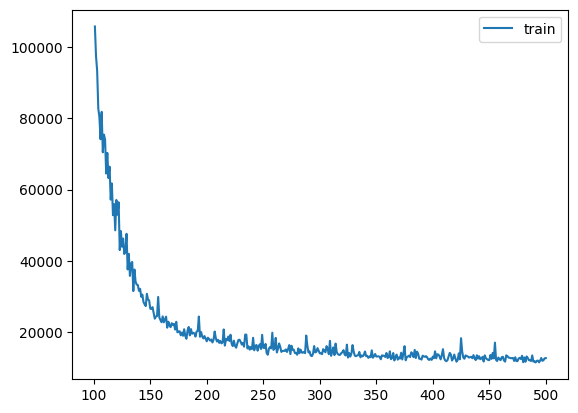

In [21]:
plt.plot(list(train_history.keys())[100:], list(train_history.values())[100:], label='train')
# plt.plot(val_history.keys(), val_history.values(), label='validation')
plt.legend()
plt.show()

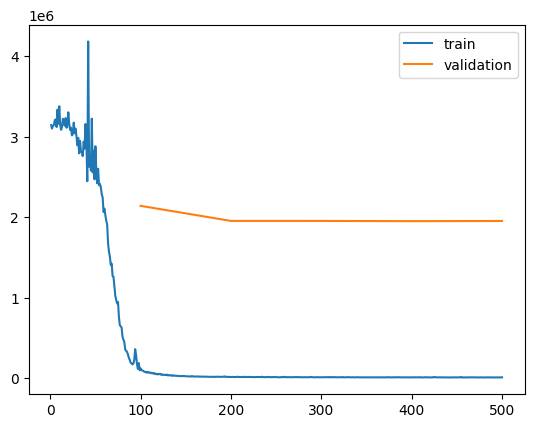

In [24]:
plt.plot(list(train_history.keys()), list(train_history.values()), label='train')
plt.plot(val_history.keys(), val_history.values(), label='validation')
plt.legend()
plt.show()

In [23]:
'''
# My results
At relu, model is stuck around 25k with 3x1000 steps with xavier
AT relu, moedl went to 9k and then exploded at 3x1000 steps with kaiming; then at 14k
At gelu, model is stuck atound 10k

Adam is better than AdamW for this task
'''

'\n# My results\nAt relu, model is stuck around 25k with 3x1000 steps with xavier\nAT relu, moedl went to 9k and then exploded at 3x1000 steps with kaiming; then at 14k\nAt gelu, model is stuck atound 10k\n\nAdam is better than AdamW for this task\n'

# TO DO

- [x] do inference, and run a partially trained model with the GUI intact
- [x] **find a way to fix the fact that our model is giving integer loss
- [x] **Fix the bug in initialisation
- [ ] implement weights and biases or tensorboard 
- [ ] improve the model
  - [x] get a better/ bigger dataset
  - [ ] hyperparameter and architecture
    - [x] better encoding
    - [ ] residual connections
    - [ ] try adamW after tuning b1 and b2
    - [x] increase embedding dim
    - [x] increase neurons in the layers
    - [x] increase layers in the network
    - [x] change loss function (maybe)
    - [ ] try diff learning rate scheduler(trapeziodal)
    - [ ] Add regularisation
      - [ ] l1,l2
      - [x] dropout
    - [x] Better initialisation
    - [x] diff optimisation algorithm

# Note